In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [30]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/HSG-Historical-Data.csv', sep=",")
df1=df.reset_index()['Price']

In [31]:
df1 = df1.str.replace(',', '', regex=True).astype(float)

# 3. Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [32]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [33]:
print(train_data.shape, test_data.shape)

(919, 1) (394, 1)


In [34]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [35]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [36]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],1 ,X_test.shape[1])

In [37]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)

(903, 1, 15)
(903,)
(378, 1, 15)
(378,)


In [38]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,15)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [39]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 8s 138ms/step - loss: 0.2224 - val_loss: 0.0010
Epoch 2/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0993 - val_loss: 0.0121
Epoch 3/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0115 - val_loss: 0.0201
Epoch 4/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0057 - val_loss: 0.0164
Epoch 5/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0040 - val_loss: 0.0148
Epoch 6/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0030 - val_loss: 0.0117
Epoch 7/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0098
Epoch 8/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0086
Epoch 9/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0075
Epoch 10/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 0.0071
Epoch 1

In [40]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

12/12 [==============================] - 0s 2ms/step


In [41]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [42]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 7345.934654329926


In [43]:
# Chuyển đổi dữ liệu kiểm tra thành danh sách
x_input = test_data[60:].reshape(1, -1)
temp_input = list(x_input[0])

from numpy import array

lst_output = []
n_steps = 15
i = 0

while i < 30:
    if len(temp_input) > 100:
        # Chuẩn bị dữ liệu đầu vào mới
        x_input = np.array(temp_input[-15:])  # Lấy đúng 100 phần tử cuối cùng
        print("{} day input {}".format(i, x_input))

        x_input = x_input.reshape((1, 1, n_steps))

        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))

        # Thêm giá trị dự đoán vào danh sách tạm thời
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])

        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))

        lst_output.extend(yhat.tolist())
        i += 1


0 day input [0.07192052 0.0710632  0.07037578 0.07397756 0.06969097 0.07534979
 0.07192052 0.07620449 0.07963376 0.07277784 0.07192052 0.07826414
 0.08409285 0.08477766 0.07363515]
0 day output [[0.10794968]]
1 day input [0.0710632  0.07037578 0.07397756 0.06969097 0.07534979 0.07192052
 0.07620449 0.07963376 0.07277784 0.07192052 0.07826414 0.08409285
 0.08477766 0.07363515 0.10794968]
1 day output [[0.11609624]]
2 day input [0.07037578 0.07397756 0.06969097 0.07534979 0.07192052 0.07620449
 0.07963376 0.07277784 0.07192052 0.07826414 0.08409285 0.08477766
 0.07363515 0.10794968 0.11609624]
2 day output [[0.12405913]]
3 day input [0.07397756 0.06969097 0.07534979 0.07192052 0.07620449 0.07963376
 0.07277784 0.07192052 0.07826414 0.08409285 0.08477766 0.07363515
 0.10794968 0.11609624 0.12405913]
3 day output [[0.13091576]]
4 day input [0.06969097 0.07534979 0.07192052 0.07620449 0.07963376 0.07277784
 0.07192052 0.07826414 0.08409285 0.08477766 0.07363515 0.10794968
 0.11609624 0.1240

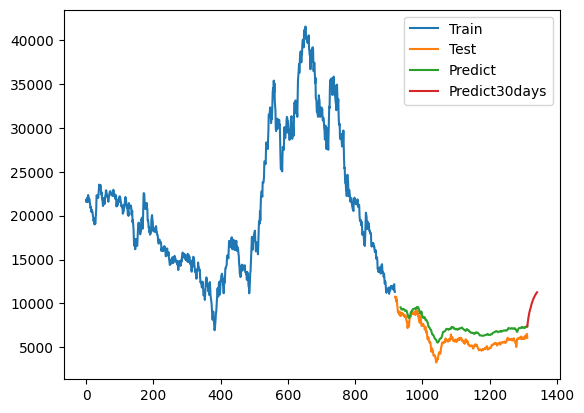

In [44]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+16, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [45]:
# Chuyển đổi dữ liệu kiểm tra thành danh sách
x_input = test_data[60:].reshape(1, -1)
temp_input = list(x_input[0])

from numpy import array

lst_output = []
n_steps = 15
i = 0

while i < 60:
    if len(temp_input) > 15:
        # Chuẩn bị dữ liệu đầu vào mới
        x_input = np.array(temp_input[-15:])  # Lấy đúng 100 phần tử cuối cùng
        print("{} day input {}".format(i, x_input))

        x_input = x_input.reshape((1, 1, n_steps))

        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))

        # Thêm giá trị dự đoán vào danh sách tạm thời
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])

        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))

        lst_output.extend(yhat.tolist())
        i += 1


0 day input [0.07192052 0.0710632  0.07037578 0.07397756 0.06969097 0.07534979
 0.07192052 0.07620449 0.07963376 0.07277784 0.07192052 0.07826414
 0.08409285 0.08477766 0.07363515]
0 day output [[0.10794968]]
1 day input [0.0710632  0.07037578 0.07397756 0.06969097 0.07534979 0.07192052
 0.07620449 0.07963376 0.07277784 0.07192052 0.07826414 0.08409285
 0.08477766 0.07363515 0.10794968]
1 day output [[0.11609624]]
2 day input [0.07037578 0.07397756 0.06969097 0.07534979 0.07192052 0.07620449
 0.07963376 0.07277784 0.07192052 0.07826414 0.08409285 0.08477766
 0.07363515 0.10794968 0.11609624]
2 day output [[0.12405913]]
3 day input [0.07397756 0.06969097 0.07534979 0.07192052 0.07620449 0.07963376
 0.07277784 0.07192052 0.07826414 0.08409285 0.08477766 0.07363515
 0.10794968 0.11609624 0.12405913]
3 day output [[0.13091576]]
4 day input [0.06969097 0.07534979 0.07192052 0.07620449 0.07963376 0.07277784
 0.07192052 0.07826414 0.08409285 0.08477766 0.07363515 0.10794968
 0.11609624 0.1240

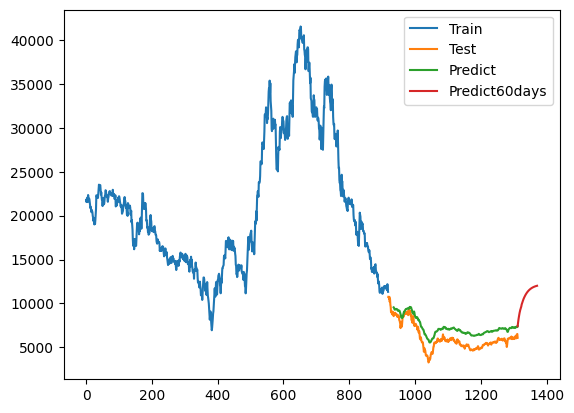

In [46]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = pd.RangeIndex(start=train_size + 16, stop=train_size + test_size, step=1)
plt.plot(pred_data_index, y_pred, label='Predict')

predict_data_index = pd.RangeIndex(start=len(df1) - 1, stop=len(df1) + 59, step=1)

lst_output_flat = np.array(lst_output).reshape(-1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output_flat.reshape(-1, 1)), label='Predict60days')

plt.legend()
plt.show()

In [47]:
# Chuyển đổi dữ liệu kiểm tra thành danh sách
x_input = test_data[60:].reshape(1, -1)
temp_input = list(x_input[0])

from numpy import array

lst_output = []
n_steps = 15
i = 0

while i < 90:
    if len(temp_input) > 15:
        # Chuẩn bị dữ liệu đầu vào mới
        x_input = np.array(temp_input[-15:])  # Lấy đúng 100 phần tử cuối cùng
        print("{} day input {}".format(i, x_input))

        x_input = x_input.reshape((1,1, n_steps))

        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))

        # Thêm giá trị dự đoán vào danh sách tạm thời
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1,1 ,n_steps))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])

        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))

        lst_output.extend(yhat.tolist())
        i += 1


0 day input [0.07192052 0.0710632  0.07037578 0.07397756 0.06969097 0.07534979
 0.07192052 0.07620449 0.07963376 0.07277784 0.07192052 0.07826414
 0.08409285 0.08477766 0.07363515]
0 day output [[0.10794968]]
1 day input [0.0710632  0.07037578 0.07397756 0.06969097 0.07534979 0.07192052
 0.07620449 0.07963376 0.07277784 0.07192052 0.07826414 0.08409285
 0.08477766 0.07363515 0.10794968]
1 day output [[0.11609624]]
2 day input [0.07037578 0.07397756 0.06969097 0.07534979 0.07192052 0.07620449
 0.07963376 0.07277784 0.07192052 0.07826414 0.08409285 0.08477766
 0.07363515 0.10794968 0.11609624]
2 day output [[0.12405913]]
3 day input [0.07397756 0.06969097 0.07534979 0.07192052 0.07620449 0.07963376
 0.07277784 0.07192052 0.07826414 0.08409285 0.08477766 0.07363515
 0.10794968 0.11609624 0.12405913]
3 day output [[0.13091576]]
4 day input [0.06969097 0.07534979 0.07192052 0.07620449 0.07963376 0.07277784
 0.07192052 0.07826414 0.08409285 0.08477766 0.07363515 0.10794968
 0.11609624 0.1240

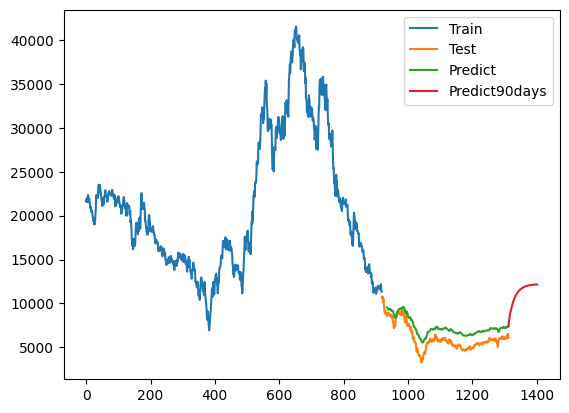

In [48]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

# Chỉ số cho dữ liệu kiểm tra
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

# Chỉ số cho dữ liệu dự đoán
pred_data_index = pd.RangeIndex(start=train_size + 16, stop=train_size + test_size, step=1)
plt.plot(pred_data_index, y_pred, label='Predict')

# Chỉ số cho dữ liệu dự báo 90 ngày
predict_data_index = pd.RangeIndex(start=len(df1) - 1, stop=len(df1) + 89, step=1)

# Chuyển đổi lst_output thành dạng phù hợp
lst_output_flat = np.array(lst_output).reshape(-1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output_flat.reshape(-1, 1)), label='Predict90days')

# Hiển thị đồ thị
plt.legend()
plt.show()